<small><i>This notebook was put together by [Anderson Banihirwe](andersy005.github.io) as part of [2017 CISL/SIParCS Research Project](https://github.com/NCAR/PySpark4Climate): **PySpark for Big Atmospheric & Oceanic Data Analysis**</i></small>


<h1 align="center"> HDF5/netCDF4 data format in Spark with H5Spark</h1>

![](https://i.imgur.com/ILcF9uH.jpg)

# Introduction

HPC applications often rely on hierarchical data formats to organize files and datasets. However, accessing data stored in HDF5/netCDF4 files is not natively supported in Spark.
    
[H5Spark](https://github.com/valiantljk/h5spark) is a Spark Package that:

- Supports Hierarchical Data Format, HDF5/netCDF4 and Rich Parallel I/O interface in Spark.

- Optimizes I/O performance on HPC.

H5Spark was designed for and tested on [Lustre parallel filesystem](http://lustre.org/).

Our objective is to test it on **NCAR's Glade**. Glade uses [high-performance GPFS shared file system technology](https://en.wikipedia.org/wiki/IBM_General_Parallel_File_System).

In this notebook, we will explore how to explore H5Spark's functionalities to transform HDF5/netCDF4 file formats into RDDs that Spark can understand. 

# 1. Import Packages

In [1]:
import pyspark
import read # H5Spark package
import h5py
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline



from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("h5spark-rdd").getOrCreate()

# Create spark context
sc = spark.sparkContext

# 2. Getting the data and creating the RDD
In this case we will use [Global Meteorological Forcing Dataset for Land Surface Modeling](https://rda.ucar.edu/datasets/ds314.0/). We will use a small chunk of this dataset, *monthly temperature means* ```4tas_monthly_1948-2008.nc``` from 1948 to 2008.

Let's load our dataset and inspect it to find out the information that we will need for H5Spark package.

In [2]:
filepath = "/Users/abanihi/Desktop/netCDF-datasets/4tas_monthly_1948-2008.nc"


**Note:**As it was indicated in the introduction section, **H5Spark package supports HDF5 and netCDF4 file formats only**!

To transform HDF5/netCDF4 data into RDDs, H5Spark read function  ```h5read(...)``` and friends take the following arguments:


| Functions                       | Output                      |
|---------------------------------|-----------------------------|
| ```h5read(sc, f, v, p)```       | A RDD of double array       |
| ```h5read_point(sc, f, v, p)``` | A RDD of (key, value) pair  |
| ```h5read_vec(sc, f, v, p)```   | A RDD of vector             |
| ```h5read_irow(sc, f, v, p)```  | A RDD of indexed row        |
| ```h5read_imat(sc, f, v, p)```  | A RDD of indexed row matrix |

Where:
- ```sc``` : SparkContext
- ```f```  : HDF5/netCDF File Path
- ```v```  : Dataset in HDF5
- ```*p``` : Partition


**Note:** *Spark partition determines the degree of parallelism = MPI processes + OpenMP

**Tip:** p > num of cores

### HDF5 and NetCDF terminology
| **HDF5**        | **NetCDF**          |
|-----------------|---------------------|
| HDF5 file       | Dataset             |
| Dataspace       | Dimensions          |
| Attribute       | Attribute           |
| dataset         | Variable            |
| Dimension scale | Coordinate variable |


The next task is to first confirm that our dataset is a netCDF-4 file format and find out what dataset(in HDF5) or variable(in netCDF4) to pass as **v** argument to H5Spark read function.

## 2.1. Find out which netCDF format it is

In [3]:
!ncdump -k /Users/abanihi/Desktop/netCDF-datasets/4tas_monthly_1948-2008.nc

netCDF-4


## 2.2. View a brief summary of our dataset with ```ncdump``` and ```h5dump``` command line tools

If you have [the ncdump command-line utility](https://www.unidata.ucar.edu/software/netcdf/workshops/2009/utilities/Ncdump.html) installed, you can issue the command below

In [4]:
!ncdump -h /Users/abanihi/Desktop/netCDF-datasets/4tas_monthly_1948-2008.nc

netcdf \4tas_monthly_1948-2008 {
dimensions:
	longitude = 360 ;
	latitude = 180 ;
	z = 1 ;
	time = UNLIMITED ; // (732 currently)
variables:
	float longitude(longitude) ;
		longitude:units = "degrees_east" ;
		longitude:point_spacing = "even" ;
		longitude:modulo = " " ;
	float latitude(latitude) ;
		latitude:units = "degrees_north" ;
		latitude:point_spacing = "even" ;
	float z(z) ;
		z:units = "level" ;
		z:positive = "up" ;
	float time(time) ;
		time:units = "months since 1948-01-01 00:00:00" ;
		time:time_origin = "01-JAN-1948:00:00:00" ;
	float tas(time, z, latitude, longitude) ;
		tas:source = "Reanalysis 6-hourly air temperature interpolated to 1.0deg with account for elevation changes, interpolated to 3-hourly and scaled to match the diurnal range and mean of the CRU TS3.0 monthly dataset" ;
		tas:name = "tas" ;
		tas:title = "monthly average bias corrected air temperature" ;
		tas:date = "01/01/48" ;
		tas:time = "00:00" ;
		tas:long_name = "Air temperature" ;
		tas:units = "K

From this summary, we can get the information that we need. Our dataset has 5 variables(netCDF4) or 5 datasets(HDF5):
- longitude
- latitude
- z
- tas
- time

We are interested in **temperature(tas)** dataset(HDF5) or variable(netCDF4). Therefore, in our case ```v = tas```.

## 2.3. Helper function to read in our data into an RDD

In [5]:
def hdf5_to_rdd():
    """A simple that loads HDF5/netCDF4 file and returns a RDD"""
    rdd_ = read.h5read(sc, (filepath, "/tas"), mode='single', partitions=12)
    return rdd_

## 2.4 Create RDD


In [6]:
tas_rdd = hdf5_to_rdd().cache()

# 3. Actions and Transformations

In [7]:
from time import time
from __future__ import print_function

## 3.1. Stats

Spark has ```stats()``` method that returns a StatCounter object that captures the mean, variance and count of the RDD’s elements in one operation.

In [8]:
# action + time 
t0 = time()
total_size = tas_rdd.count()
tt = time() - t0

In [9]:
print("The total size is {}".format(total_size))
print("Count done in {} seconds".format(round(tt,3)))

The total size is 732
Count done in 1.774 seconds


In [10]:
print(tas_rdd.first())

[[[ 254.5070343   254.48086548  254.84159851 ...,  255.10877991
    255.17124939  254.9515686 ]
  [ 256.05981445  256.07855225  256.35101318 ...,  256.40127563
    256.42196655  256.29632568]
  [ 256.27810669  256.22521973  256.60891724 ...,  257.12588501
    257.05773926  256.77496338]
  ..., 
  [ 229.79891968  230.23980713  231.19805908 ...,  230.55310059
    230.12684631  229.8754425 ]
  [ 229.60472107  229.7421875   229.95570374 ...,  230.46591187
    229.83030701  229.54327393]
  [ 229.84117126  229.88601685  229.7243042  ...,  230.47297668
    229.80038452  229.58973694]]]


In [11]:
# Find the shape of each element in our rdd
shape = tas_rdd.take(1)[0].shape
print("Shape: {}".format(shape))

Shape: (1, 180, 360)


From shape and total size values we can confirm that our netCDF4 data was correctly transformed to rdd.

The details of our rdd are as follows:
- Our RDD has 732 elements, we can think of it as a textfile with 732 lines
- Each row in our RDD represents entries for each month since 1948 to 2008 $(\text{total_num_months}$ $= (2008 - 1948 + 1 ) * 12 = 732)$

In [12]:
# Call stats method on our tas_rdd and return the statistics as a dictionary object
t0 = time()
stats = tas_rdd.stats().asDict()
tt = time() - t0
print("Stats calculated in {} seconds".format(round(tt,3)))

Stats calculated in 0.61 seconds


In [13]:
stats

{'count': 732,
 'max': array([[[ 258.81048584,  258.8755188 ,  258.76220703, ...,  258.62866211,
           258.55703735,  258.59851074],
         [ 260.11993408,  260.05078125,  259.91586304, ...,  260.10275269,
           260.13079834,  260.12475586],
         [ 260.21725464,  260.04022217,  259.67346191, ...,  259.9486084 ,
           260.12240601,  260.21176147],
         ..., 
         [ 267.81463623,  267.82263184,  267.84985352, ...,  267.79379272,
           267.81878662,  267.82574463],
         [ 267.72949219,  267.73959351,  267.77346802, ...,  267.71792603,
           267.71633911,  267.71646118],
         [ 267.65365601,  267.65750122,  267.6763916 , ...,  267.64300537,
           267.63702393,  267.6378479 ]]], dtype=float32),
 'mean': array([[[ 225.46681213,  225.42602539,  225.36627197, ...,  225.57104492,
           225.57400513,  225.52008057],
         [ 226.50375366,  226.39845276,  226.29148865, ...,  226.72172546,
           226.6933136 ,  226.60887146],
         

**What just happened?**

To see how the stats method works, let's use the following simple example:

In [14]:
# Create three 3-d numpy arrays with shape (3, 3, 3)
a = np.ones((3, 3, 3))
b = np.full((3, 3, 3), 5)
c = np.full((3, 3, 3), 9)

In [15]:
a,b,c

(array([[[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],
 
        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],
 
        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]]]), array([[[5, 5, 5],
         [5, 5, 5],
         [5, 5, 5]],
 
        [[5, 5, 5],
         [5, 5, 5],
         [5, 5, 5]],
 
        [[5, 5, 5],
         [5, 5, 5],
         [5, 5, 5]]]), array([[[9, 9, 9],
         [9, 9, 9],
         [9, 9, 9]],
 
        [[9, 9, 9],
         [9, 9, 9],
         [9, 9, 9]],
 
        [[9, 9, 9],
         [9, 9, 9],
         [9, 9, 9]]]))

Let's create a rdd from these three arrays.

In [18]:
arr = sc.parallelize([a, b, c], 4)

In [19]:
# How many elements in our rdd?
arr.count()

3

In [20]:
# First element in our rdd
arr.first()

array([[[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]]])

By applying the stats method to this rdd, Spark is going to return a stats counter object containing a variety of stats.
Spark does this in our operation.

In [21]:
arr_stats = arr.stats().asDict()

In [22]:
arr_stats

{'count': 3, 'max': array([[[ 9.,  9.,  9.],
         [ 9.,  9.,  9.],
         [ 9.,  9.,  9.]],
 
        [[ 9.,  9.,  9.],
         [ 9.,  9.,  9.],
         [ 9.,  9.,  9.]],
 
        [[ 9.,  9.,  9.],
         [ 9.,  9.,  9.],
         [ 9.,  9.,  9.]]]), 'mean': array([[[ 5.,  5.,  5.],
         [ 5.,  5.,  5.],
         [ 5.,  5.,  5.]],
 
        [[ 5.,  5.,  5.],
         [ 5.,  5.,  5.],
         [ 5.,  5.,  5.]],
 
        [[ 5.,  5.,  5.],
         [ 5.,  5.,  5.],
         [ 5.,  5.,  5.]]]), 'min': array([[[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],
 
        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],
 
        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]]]), 'stdev': array([[[ 4.,  4.,  4.],
         [ 4.,  4.,  4.],
         [ 4.,  4.,  4.]],
 
        [[ 4.,  4.,  4.],
         [ 4.,  4.,  4.],
         [ 4.,  4.,  4.]],
 
        [[ 4.,  4.,  4.],
         [ 4.,  4.,  4.],
         [ 4.,  4

In [23]:
d = np.array([a, b, c])
d.shape

(3, 3, 3, 3)

In [24]:
d.sum(0), d.max(0), d.min(0), d.mean(0)

(array([[[ 15.,  15.,  15.],
         [ 15.,  15.,  15.],
         [ 15.,  15.,  15.]],
 
        [[ 15.,  15.,  15.],
         [ 15.,  15.,  15.],
         [ 15.,  15.,  15.]],
 
        [[ 15.,  15.,  15.],
         [ 15.,  15.,  15.],
         [ 15.,  15.,  15.]]]), array([[[ 9.,  9.,  9.],
         [ 9.,  9.,  9.],
         [ 9.,  9.,  9.]],
 
        [[ 9.,  9.,  9.],
         [ 9.,  9.,  9.],
         [ 9.,  9.,  9.]],
 
        [[ 9.,  9.,  9.],
         [ 9.,  9.,  9.],
         [ 9.,  9.,  9.]]]), array([[[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],
 
        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]],
 
        [[ 1.,  1.,  1.],
         [ 1.,  1.,  1.],
         [ 1.,  1.,  1.]]]), array([[[ 5.,  5.,  5.],
         [ 5.,  5.,  5.],
         [ 5.,  5.,  5.]],
 
        [[ 5.,  5.,  5.],
         [ 5.,  5.,  5.],
         [ 5.,  5.,  5.]],
 
        [[ 5.,  5.,  5.],
         [ 5.,  5.,  5.],
         [ 5.,  5.,  5.]]]))

**Conclusion:**
- Spark's ```stas()``` method uses an axis running vertically downwards across rows (axis 0) to apply the sum, mean, max, min, std, variance operations.

## 3.2 Further stats exploration
Let's extract mean values from the stats dict object and do some analysis.

In [25]:
means = stats["mean"]
means

array([[[ 225.46681213,  225.42602539,  225.36627197, ...,  225.57104492,
          225.57400513,  225.52008057],
        [ 226.50375366,  226.39845276,  226.29148865, ...,  226.72172546,
          226.6933136 ,  226.60887146],
        [ 226.94291687,  226.83609009,  226.71694946, ...,  227.20068359,
          227.13087463,  227.0447998 ],
        ..., 
        [ 247.79217529,  247.8140564 ,  247.83401489, ...,  247.73457336,
          247.74919128,  247.76838684],
        [ 247.77876282,  247.78096008,  247.75949097, ...,  247.74057007,
          247.74029541,  247.75305176],
        [ 247.87211609,  247.86749268,  247.84742737, ...,  247.86132812,
          247.85772705,  247.86134338]]], dtype=float32)

In [26]:
print("Shape: {}\n".format(means.shape))
print("Size: {}\n".format(means.size))

Shape: (1, 180, 360)

Size: 64800



In [27]:
means.dtype

dtype('float32')

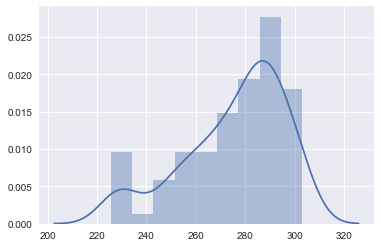

In [30]:
sns.distplot(means[0][:, 0]);

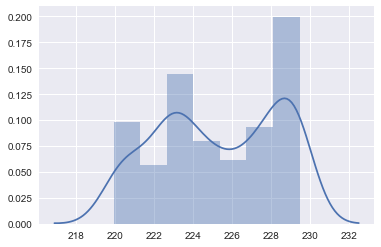

In [31]:
sns.distplot(means[0][1, :]); 

In [32]:
from datetime import datetime, timedelta
from collections import OrderedDict

In [33]:
def generate_list_of_months(dates_range):
    """
    - Args:  dates interval
    - Returns: List of all the months in the given dates interval
    
    """
    start, end = [datetime.strptime(_, "%Y-%m-%d") for _ in dates_range]
    list_of_months = OrderedDict(((start + timedelta(_)).strftime(r"%b-%y"), None) 
                                   for _ in xrange((end - start).days)
                                ).keys()
    return list_of_months

In [34]:
dates_range = ["1948-01-01", "2008-12-31"]
list_of_months = generate_list_of_months(dates_range)

In [35]:
len(list_of_months)

732

In [36]:
list_of_months[0:12]

['Jan-48',
 'Feb-48',
 'Mar-48',
 'Apr-48',
 'May-48',
 'Jun-48',
 'Jul-48',
 'Aug-48',
 'Sep-48',
 'Oct-48',
 'Nov-48',
 'Dec-48']

In [37]:
# Create an RDD for the months
months_rdd = sc.parallelize(list_of_months, 12).sortBy(lambda x: x, numPartitions=12)

In [38]:
months_rdd.count()

732

In [39]:
months_rdd.take(1)

['Apr-00']

## Zip Transformation

Create an new RDD containing pairs whose key is the item in months_rdd, and whose value is that item's corresponding element(same partition, same index) in tas_rdd

In [40]:
month_ta_rdd = months_rdd.zip(tas_rdd)

In [41]:
month_ta_rdd.take(1)

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 23.0 failed 1 times, most recent failure: Lost task 0.0 in stage 23.0 (TID 123, localhost, executor driver): org.apache.spark.SparkException: Can only zip RDDs with same number of elements in each partition
	at org.apache.spark.rdd.RDD$$anonfun$zip$1$$anonfun$apply$27$$anon$2.hasNext(RDD.scala:860)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.rdd.RDD$$anonfun$zip$1$$anonfun$apply$27$$anon$2.foreach(RDD.scala:856)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:504)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:328)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1951)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:269)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1925)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1938)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1951)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:441)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Can only zip RDDs with same number of elements in each partition
	at org.apache.spark.rdd.RDD$$anonfun$zip$1$$anonfun$apply$27$$anon$2.hasNext(RDD.scala:860)
	at scala.collection.Iterator$class.foreach(Iterator.scala:893)
	at org.apache.spark.rdd.RDD$$anonfun$zip$1$$anonfun$apply$27$$anon$2.foreach(RDD.scala:856)
	at org.apache.spark.api.python.PythonRDD$.writeIteratorToStream(PythonRDD.scala:504)
	at org.apache.spark.api.python.PythonRunner$WriterThread$$anonfun$run$3.apply(PythonRDD.scala:328)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1951)
	at org.apache.spark.api.python.PythonRunner$WriterThread.run(PythonRDD.scala:269)


In [42]:
f = h5py.File(filepath, 'r')

In [43]:
time_dset = f["time"]
lat_dset = f["latitude"]
lon_dset = f["longitude"]
z_dset = f["z"]

In [44]:
time_dset.shape

(732,)

In [45]:
time_dset[...]

array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,
        108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,
        117.,  118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,
        126.,  127.,

In [46]:
lat_dset.shape

(180,)

In [47]:
lat_dset[...]

array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5,
       -80.5, -79.5, -78.5, -77.5, -76.5, -75.5, -74.5, -73.5, -72.5,
       -71.5, -70.5, -69.5, -68.5, -67.5, -66.5, -65.5, -64.5, -63.5,
       -62.5, -61.5, -60.5, -59.5, -58.5, -57.5, -56.5, -55.5, -54.5,
       -53.5, -52.5, -51.5, -50.5, -49.5, -48.5, -47.5, -46.5, -45.5,
       -44.5, -43.5, -42.5, -41.5, -40.5, -39.5, -38.5, -37.5, -36.5,
       -35.5, -34.5, -33.5, -32.5, -31.5, -30.5, -29.5, -28.5, -27.5,
       -26.5, -25.5, -24.5, -23.5, -22.5, -21.5, -20.5, -19.5, -18.5,
       -17.5, -16.5, -15.5, -14.5, -13.5, -12.5, -11.5, -10.5,  -9.5,
        -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,  -1.5,  -0.5,
         0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,
         9.5,  10.5,  11.5,  12.5,  13.5,  14.5,  15.5,  16.5,  17.5,
        18.5,  19.5,  20.5,  21.5,  22.5,  23.5,  24.5,  25.5,  26.5,
        27.5,  28.5,  29.5,  30.5,  31.5,  32.5,  33.5,  34.5,  35.5,
        36.5,  37.5,

In [48]:
lon_dset.shape

(360,)